In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import util
from sklearn import manifold, datasets
from sklearn.decomposition import PCA


# Important: utiliser les données prétraitées
csv_path = 'data/dataframe.csv'

In [3]:
df = pd.read_csv(csv_path)
df.head()
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30,shuffle = True)

# Premier essai avec des arbres de décision 

In [33]:
from sklearn.tree import DecisionTreeClassifier
clf_first = DecisionTreeClassifier(max_depth=5, random_state=0)

clf_first.fit(X_train, y_train)

y_pred = clf_first.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score

print('Test score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf_first.predict(X_train)

print('Train score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Test score with criterion gini index: 0.3956
Train score with criterion gini index: 0.4015


### Analyse: 

Le score est pas super bon mais au moins on n'overfit pas : la différence entre le score d'entraînement et le score de test est faible.
Essayons de trouver la profondeur optimale pour éviter l'overfit et avoir le meilleur score

In [48]:
depth_clfs = [DecisionTreeClassifier(max_depth=k, random_state=0) for k in range(1,30)]
accuracy_train = []
accuracy_test = []
for clf in depth_clfs:
    clf.fit(X_train, y_train)
    accuracy_train.append(clf.score(X_train, y_train))
    accuracy_test.append(clf.score(X_test, y_test))


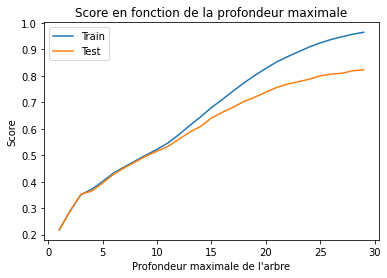

Le meilleur score sans overfit semble être pour une profondeur de 10 qui nous donne un score de 0.5334355623708247


In [50]:
plt.plot([k for k in range(1,30)],accuracy_train,label='Train')
plt.plot([k for k in range(1,30)],accuracy_test,label='Test')

plt.legend()
plt.title("Score en fonction de la profondeur maximale")
plt.xlabel("Profondeur maximale de l'arbre")
plt.ylabel("Score")
plt.show()

print(f"Le meilleur score sans overfit semble être pour une profondeur de 10 qui nous donne un score de {accuracy_test[10]}")
meilleur_clf = depth_clfs[10]


### Analyse: 

Les deux courbes commencent à se séparer autour d'une profondeur maximale de 10. On retiendra donc le classifieur de profondeur 10 pour notre problème. 

Essayons maintenant de jeter un oeil à notre matrice de confusion:

<Figure size 1152x864 with 0 Axes>

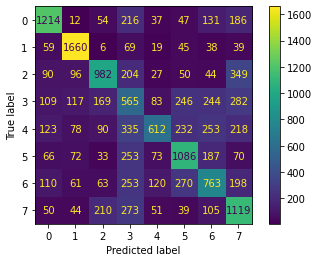

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(meilleur_clf,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

On constate que le gros de l'incertitude réside chez les éléments qui eux mêmes ne sont pas certains de leur orientation politique ou encore sur les partis moins clivants et plus centristes comme le parti vert et dans une moindre mesure le NDP. Pour d'auters partis plus spécifiques comme le Bloc ou encore les classiques conservateur/libéral, le taux de vrais positifs est beaucoup plus élevé.

# Forêts aléatoires :

In [90]:
from sklearn.ensemble import RandomForestClassifier 
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_forest.fit(X_train, y_train)
clf_forest_train_score = clf_forest.score(X_train, y_train)
clf_forest_test_score = clf_forest.score(X_test, y_test)

print(f"clf_forest train score : {clf_forest_train_score}")
print(f"clf_forest train score : {clf_forest_test_score}")

clf_forest train score : 0.42678312469788143
clf_forest train score : 0.4233615574371625


<Figure size 1152x864 with 0 Axes>

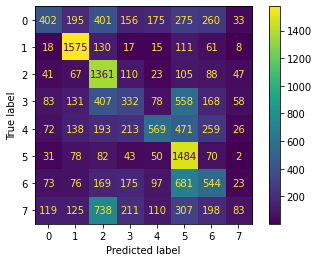

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(clf_forest,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

Avec un score de seulement 0.42 on a un classifieur qui n'est clairement pas bon, il nous faut donc jouer avec les hyperparamètres pour essayer de trouver la meilleure version de ce dernier

In [113]:
parameters = {
    "n_estimators":[50,250],
    "max_depth":[12,24,32,None]
    
}

from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(clf_forest,parameters,cv=10)
cv.fit(X_train, y_train.ravel())

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             param_grid={'max_depth': [12, 24, 32, None],
                         'n_estimators': [50, 250]})

In [114]:
print(f'Best parameters are: {cv.best_params_}')
print("\n")
mean_score = cv.cv_results_['mean_test_score']
std_score = cv.cv_results_['std_test_score']
params = cv.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': None, 'n_estimators': 250}


0.637 + or -0.006 for the {'max_depth': 12, 'n_estimators': 50}
0.638 + or -0.005 for the {'max_depth': 12, 'n_estimators': 250}
0.859 + or -0.006 for the {'max_depth': 24, 'n_estimators': 50}
0.863 + or -0.005 for the {'max_depth': 24, 'n_estimators': 250}
0.875 + or -0.005 for the {'max_depth': 32, 'n_estimators': 50}
0.878 + or -0.005 for the {'max_depth': 32, 'n_estimators': 250}
0.876 + or -0.005 for the {'max_depth': None, 'n_estimators': 50}
0.878 + or -0.006 for the {'max_depth': None, 'n_estimators': 250}


In [119]:
best_clf_forest = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=10)
best_clf_forest.fit(X_train, y_train)
best_clf_forest_train_score = clf_forest.score(X_train, y_train)
best_clf_forest_test_score = clf_forest.score(X_test, y_test)

print(f"best clf_forest train score : {best_clf_forest_train_score}")
print(f"best clf_forest train score : {best_clf_forest_test_score}")

best clf_forest train score : 0.4250662577300685
best clf_forest train score : 0.4302286819121275


In [125]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_test = best_clf_forest.predict(X_test)
score_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test,average="macro")

y_pred_train = best_clf_forest.predict(X_train)
score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_train, y_pred_train,average="macro")


print(f"best clf_forest test accuracy score : {score_test} \n\
    best clf_forest test f1 score : {f1_test}")
print(f"best clf_forest train accuracy score : {score_train}\n\
    best clf_forest train f1 score : {f1_test}")

best clf_forest test accuracy score : 0.891992799519968 
    best clf_forest test f1 score : 1.0
best clf_forest train accuracy score : 1.0
    best clf_forest train f1 score : 1.0


<Figure size 1152x864 with 0 Axes>

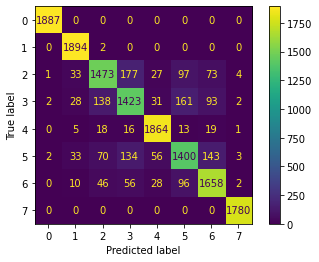

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [126]:
plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(best_clf_forest,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

A première vue, au vu de la différence entre le score parfait sur l'ensemble d'entraînement et le score sur l'ensemble de test très élevé, on pourrait se dire que les forêts aléatoires, déjà propices à l'overfitting, sont en train de violemment overfit mais ce n'est pas vraiment le cas comme on peut le voir avec les excellents résultats dans la matrice de confusion. De plus les coefficients obtenus pour nos forets aléatoires ont été obtenues par une recherche en grille ET pour être absolument certain une validation croisée 10-fold! Cela fait que le temps de calcul a été très long (de l'ordre de la demi-heure) mais cela nous assure que la forêt ne capte pas des données trop spécifiques à un sous ensemble particulier de l'ensemble des données.

### Résultat final avec les forêts aléatoires: 
Accuracy : 89.2%
F1-score : 1.0 (curieusement élevé)